In [1]:
# run this cell to have all imports you'll need
from scipy.stats import bernoulli, beta, binom, poisson
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.special import expit

# Sampling from distribuions

## Exercise 1

Use the `bernoulli` distribution from `scipy.stats` to sample a coin flip, with probability heads equal to 0.3

In [2]:
bernoulli(p=0.3).rvs()

1

Write a function that takes in a parameter $p$ denoting the probability of heads, and $n$ the number of coin flips. This function will then generate those $n$ flips and return the result. Test this function by generating $n=1000$ samples with probability $p=0.3$, then plot that result as a histogram. Remember to label your axis!

Text(0, 0.5, 'counts')

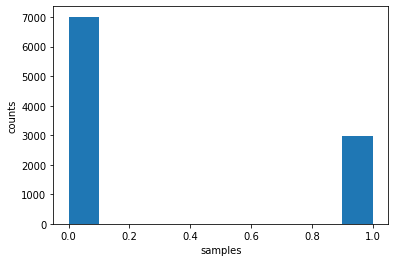

In [4]:
def sample_bern(p, n):
    return bernoulli(p=p).rvs(n)

samps = sample_bern(0.3, 10000)

plt.hist(samps);
plt.xlabel("samples")
plt.ylabel("counts")

Repeat the above 100 different times, but with $p=0.5$. Then add up all the samples and plot the sum as a histogram again. 

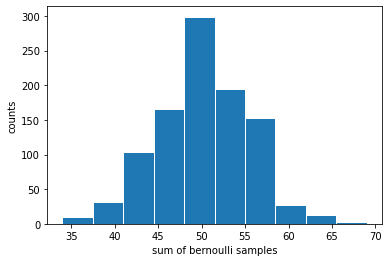

In [6]:
res = np.array([sample_bern(0.5, 1000) for i in range(100)]).sum(0)
plt.hist(res, edgecolor="white");
plt.xlabel("sum of bernoulli samples")
plt.ylabel("counts");

A family of distributions that we haven't looked at yet is the Binomial family. One way to conceptualize the Binomial family is through the Bernoulli family. Say we flip a coin that has probability $p = heads = 0.5$  10 times, and add up the number of heads that appeared. This is equivalent to a random sample from a Binomial distribution with parameters $n=10, p=0.5$

* use this information to code up the same thing you did in the previous question, but this time using a Binomial distribution instead of a Bernoulli

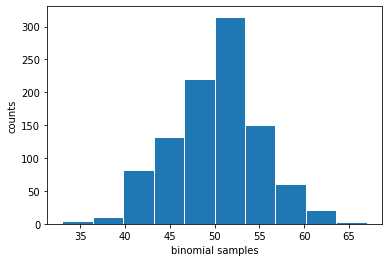

In [5]:
binom_samps = np.array([binom(100, 0.5).rvs() for i in range(1000)])
plt.hist(binom_samps, edgecolor="white")
plt.xlabel("binomial samples")
plt.ylabel("counts");

# Distributions and link functions - practice coding math

## Exercise 2

Use the equation:


 $$p(y; x, w, g(\cdot)) = \frac{g(x, w)^y e ^{-g(x, w)}}{y!}$$
 
 To code up the proability mass function of a poisson distribution. 
 
 Make sure it's output is the same the pmf of the poisson object from `scipy.stats`, that is
 
 `np.isclose(poisson_pmf(y, x, w, inv_link_fn), poisson.pmf(y, mu=np.exp(x*w)), atol=0.001)` should evaluate to `True`
 
 The `math` library contains the factorial function you'll need.

In [12]:
def poisson_inv_link(z):
    return np.exp(z)

def poisson_pmf(y, x, w, inv_link_fn):
    mu = inv_link_fn(x*w)
    
    p = mu**y * np.exp(-mu) / math.factorial(y)
    
    return p


#below should evaluatte to True, if implemented correctly
np.isclose(poisson_pmf(10, 3, 3, poisson_inv_link), poisson.pmf(10, mu=np.exp(3*3)), rtol=0.00001)

True

Repeat the previous exercise but now for a bernoulli distribution

$$p(y; x, w, \sigma(\cdot)) = \sigma(xw)^y \big(1 - \sigma(xw)\big)^{1 - y}$$

In [13]:
def bern_inv_link(z):
    return 1 / (1 + np.exp(-z))

def bernoulli_pmf(y, x, w, inv_link_fn):
    mu = inv_link_fn(x*w)
    
    p = mu**y * (1 - mu)**(1 - y)
    
    return p

#below should evaluatte to True, if implemented correctly
np.isclose(bernoulli_pmf(1, 8, 0.6, bern_inv_link), bernoulli.pmf(1, expit(8*0.6)), rtol=0.00001)

True

# Modelling

## Exercise 3

Recall the mouse in the experiment box scenario from the lecture notebook. The mouse has two levers to choose from, one which delivers food, and another which delivers water. 

We want to know what the mouses preference for water is on a particular day of the week. 

* What distribution can be used to model the mouses choice in this experiment?

In [14]:
from scipy.stats import bernoulli

Denote the moues preference for water with the parameter $\theta$, and say that $P(choice = water) = \theta$ corresponds to the probability that the mouse selects water. Additionally, there is data available. We have observed the mouses choices. We'll code $water = 1$, and $food = 0$

$d = \big(0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ... \big)$

We're going to use the data to help us make an inference on what the preference for water is

If we write out our query of wanting to know the mouse's prefrence for water it's: 

$$P(\theta | d)$$

 * now apply Bayes rule (write it in markdown in the cell below):


$$p(\theta | d) = \frac{P(d | \theta) P(\theta)}{\int P(d | \theta) P(\theta) \mathop{d \theta}}$$


* Remember that the denominator $P(d)$ can be written in another way, write that out in the cell below in markdown

$$
P(d)= \int P(d | \theta) P(\theta) \mathop{d \theta} \approx \sum_{j=1}^{2000} P(d | \theta_j) P(\theta_j) \Delta_{\theta_j} 
$$

the reason we need to take into account $\Delta_{\theta_j}$ is because we are approximating an integral. Recall from calculus that one conceptualization of an integral of a curve is drawing tiny rectangles, computing the area of each tiny rectangle, and summing that up. That is what we are doing. For a rectangle area = height $\times$ width. $P(d | \theta) P(\theta)$ is the height of the little rectangles, $\Delta_{\theta_j}$ is the width. 

Let's say we've observed the mouse's choices on previous days, and have counted the number of times it choose water and the number of times it choose food. With that information we assign a prior distribution to $P(\theta)$. Out of 868 choices it chose water 238 times, and food 630 times. We'll use this information to create a prior distribution for $\theta$ below


In [16]:
prior_water_choices = 358
prior_total_choices = 868
prior_food_choices = prior_total_choices - prior_water_choices
prior_water = beta(prior_water_choices, prior_food_choices)
prior_water; # this is a set beta distribution

Let's assume a discrete grid for all the values that $\theta$ can take on, and set some other important variables

In [17]:
possible_thetas = np.linspace(0.001, 0.99, 2000)

true_water_pref = 0.56 # ground truth

data = bernoulli(p=true_water_pref).rvs(200) # generate some data from the ground truth

### Likelihood

When you have an array of data points as we do, how do we compute $P(d | \theta)$? The first thing to realize is that $P(d | \theta)$ is a shortened version of: 

$$P(0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ... | \theta)$$

additionally we make an assumption of independence and identitically distributed. This means that we are assuming each sample uses the same distributtion for it's likelihood function, and that each sample is independent of one another (obviously this latter assumption is wrong). 

Now recall that if two events are independent then: $P(a, b) = P(a)P(b)$. Use this fact to both write out in markdown the from of the likelihood, and code it up. 

$$P(d | \theta) = \prod_{i=1}^{N} P(d_i|\theta)$$

In [21]:
# here's an example P( 1 | theta = 0.5): bernoulli(p=0.5).pmf(1)
# use that to computue P(d | theta), for the moment assume a theta of 0.5
print(bernoulli(p=0.5).pmf(data).prod()) # numpy automatically computes this for all values in data
# here is an example using a for loop, where we iterate over all values in data manually
answer = 1
for d_i in data:
    answer = answer * bernoulli(p=0.5).pmf(d_i)
print(answer)

6.223015277861142e-61
6.223015277861142e-61


In [63]:
# this is the step that we take at each value possible theta 
dtheta = np.concatenate([np.array([0.00049475]), np.diff(possible_thetas)])

# this is a smarter way to compute that, making it into an array is not required, but doing it for the 
# porpuse of matching the lengths of all arrays
dtheta = np.ones(2000) * (0.99 - 0.001) / 2000


Repeat the code portion of what you've done above, but this time compute that likelihood for all values in the array `possible_thetas`, then normalize it

In [54]:
# first we compute the likelihood. As above it computes the pmf of all of the data at once, for each
# value in possible_thetas. liks is an array of 2000 values (one for each theta)
# here we use a list comprehension
liks = np.array([bernoulli(theta_j).pmf(data).prod() for theta_j in possible_thetas])

# # and the same thing but using two for loops
# liks = []

# #this one will take a lot longer than the vectorized numpy version
# for theta_j in possible_thetas:
#     lik_j = 1
#     for d_i in data:
#         lik_j = lik_j * bernoulli(theta_j).pmf(d_i)
#     liks.append(lik_j)

# converting to numpy array, by habit
#liks = np.array(liks)

Text(0, 0.5, 'posterior density')

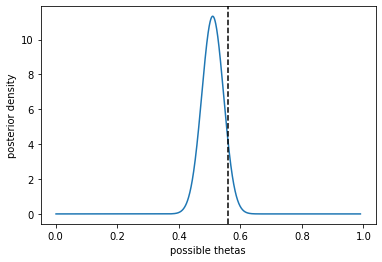

In [64]:
plt.plot(possible_thetas, liks / (liks * dtheta).sum())
plt.axvline(true_water_pref, linestyle="--", color="black", label="true water pref")
plt.xlabel("possible thetas")
plt.ylabel("posterior density")

Do what you just did again, however this time take into account the prior distribution over $\theta$. Use the function that was created for you `prior_water`, it has a probability density method associated with it, here's how you'd use it: 

`prior_water.pdf(theta_value)`

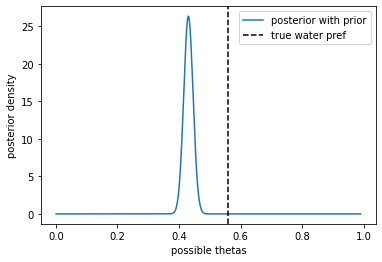

In [65]:
liksprior = np.array([
    bernoulli(theta_j).pmf(data).prod() * prior_water.pdf(theta_j)
    for theta_j in possible_thetas
])

plt.plot(possible_thetas, liksprior / (liksprior * dtheta).sum(), label="posterior with prior")

plt.axvline(true_water_pref, linestyle="--", color="black", label="true water pref")
plt.xlabel("possible thetas")
plt.ylabel("posterior density")
plt.legend()

Plot the two distributions, and observe the effect of the prior. Use the information you gather from plotting these distributions to say something about the mouses preference for water, explain what the prior does, is it a good prior in this situation?

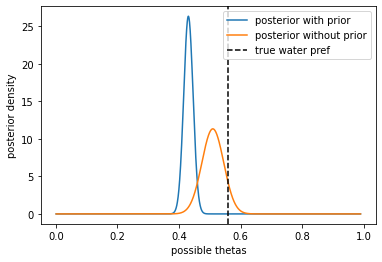

In [66]:

plt.plot(possible_thetas, liksprior / (liksprior * dtheta).sum(), label="posterior with prior")

plt.plot(possible_thetas, liks / (liks * dtheta).sum(), label="posterior without prior")

plt.axvline(true_water_pref, linestyle="--", color="black", label="true water pref")
plt.xlabel("possible thetas")
plt.ylabel("posterior density")
plt.legend()

Explain yourself here: 

# Modelling - conjugacy

## Exercise 4

You may have noticed that in the exercise above we aren't exploiting certain algebraic manipulations that give us closed form solutions for our inference problem. Instead, we made an approximation to the integral using a discrete set of points (the 2000 evenly spaced `theta` values). In this exercise you'll use conjugate distributions. 

In probability theory certain distributions are conjugate to one another. All this means is that they have very similiar looking expressions that allow us to allegbraically manipulate parameters of the distributions. For a concerete example, recall the Bernoulli distribution:

$$p(d_i; \theta) = \theta^{d_i} (1 - \theta)^{1 - d_i}$$

and here is a Beta distribution, which is conjugate to the Bernoulli family:

$$p(\theta; \alpha, \beta) = \frac{1}{Z} \theta^{\alpha - 1} (1 - \theta)^{\beta - 1}$$

notice how similar they are to one another. This allows us to algebraically combine similar terms between distributions: 

$$\theta^{d_i}\theta^{\alpha - 1} = \theta^{d_i + \alpha - 1}$$

$$(1 - \theta)^{1 - d_i} (1 - \theta)^{\beta - 1} = (1 - \theta)^{\beta - d_i}$$

which means if we write out $p(d_i; \theta) \times p(\theta; \alpha, \beta)$, and for the moment ignore $Z^{-1}$, then we have

$$p(d_i; \theta) p(\theta; \alpha, \beta) \propto \theta^{d_i + \alpha - 1} (1 - \theta)^{\beta - d_i}$$

Why is this useful? It turns out that it is exact inference from Bayes rule. 

Recall: $P(\theta | d_i) \propto P(d_i|\theta)P(\theta)$, and that is exactly what we have in the statement above. Taking this a step further, let's introduce some variables so that we can explictly write this as posterior distribution (which will be a beta distribution) over $\theta$, that looks like the Beta distribution initially introduced

set: 

$$\alpha' = d_i + \alpha$$

and 

$$\beta' = 1 - d_i + \beta$$

doing so gives us a distribution that is exactly like the initial beta distribution but with updated $\alpha$ and $\beta$ parameters: 

$$P(\theta | d_i, \alpha', \beta') = \frac{1}{Z} \theta^{\alpha' - 1} (1 - \theta)^{\beta' - 1}$$

one last thing (not super important, but incase you were curious): 

$$\frac{1}{Z} = \frac{\Gamma(\alpha' + \beta')}{\Gamma(\alpha')\Gamma(\beta')}$$

* Your task is to code up and solve this inference problem using the array of data provided in the exercise above. Make use of the math that is shown above to iteratively update the appropriate parameters. Then plot the posterior distribution over $\theta$

In [67]:
# by setting each of these values to 1, this assumes that P(\theta) is a uniform prior
alpha_prime = 1
beta_prime = 1

for d_i in data:
    # translating the formulas above, verbatim
    alpha_prime = alpha_prime + d_i
    
    beta_prime = 1 - d_i + beta_prime

In [68]:
posterior = beta(alpha_prime, beta_prime)

Text(0, 0.5, 'posterior density')

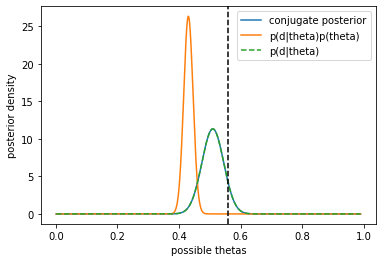

In [69]:
plt.plot(possible_thetas, posterior.pdf(possible_thetas),
        label="conjugate posterior")
plt.plot(possible_thetas, liksprior / (liksprior * dtheta).sum(), 
        label="p(d|theta)p(theta)")
plt.plot(possible_thetas, liks / (liks * dtheta).sum(),
        label="p(d|theta)", linestyle="--")
plt.axvline(true_water_pref, linestyle="--", color="black")
plt.legend()
plt.xlabel("possible thetas")
plt.ylabel("posterior density")